# Experiment: Varying-Strength Attractors
In this experiment, we place four agents in a time-varying potential field, whereby each agent accelerates according to a vector field.

For this specific example, the potential field consists of of two varying-strength attractors:

<img src="./images/vec_field_var.png">

This vector field shows how the two attractors change over time. For this example the left-hand side attractor starts as more attractive. Over time the right-hand side one becomes more attractive and the left one reduces in strength.

In [1]:
# Imports
import random
import pickle
import numpy as np
np.random.seed(seed=0)
%matplotlib inline 

# Import: Our code
import nb_utils
import GP_deriv
import GP_vec
from MAS_exp import ContinuousEnvironment
from utils_synthetic import plot_laplacian

### Whether to load or run results:
* Set to False to run model. It can take up to 20 minutes on a MacBook Pro (2015) but runs faster if more memory is available.

In [2]:
load_dict = True 

### Initialise agents and environment
We set the four agent starting locations to be evenly spaced in the environment. We also set the time-resolution (N) and the space-resolution (M) for which we calculate values of the Laplacian.

In [3]:
N = 200 # Time-resolution
M = 10  # Space-resolution
agent_positions = [[2.,1.], [2,-1], [-2,-1], [-2,1]]

env = ContinuousEnvironment(N, M)
env.initialise_agents(agent_positions)

### Set potential field

We set the means and covariances of a Gaussian mixture model to determin our potential field, where each Gaussian acts as an attractor:

Varying strength attractor:

$$ \phi_2(\mathbf{x},t) = \sum^K_{i=1}\alpha_i \mathcal{N}\big(\mathbf{m}_i, (\sin(t+\beta_i) + c_i)\mathbf{I} \big) $$


In [4]:
# means:
mu1 = lambda x: np.array([[-1.5], [0.]])
mu2 = lambda x: np.array([[1.5], [0.]])
mean_list = list([mu1,mu2])
# covariances
cov1 = lambda x: (np.sin(x) + 2.1) * np.eye(2)
cov2 = lambda x: (np.cos(x) + 2.1) * np.eye(2)
cov_list = list([cov1,cov2])

## Step through environment to simulate agent trajectories


In [5]:
env.calculate_trajectories(mean_list, cov_list)
x_train, y_train, t_train, x_test, y_test, t_test = env.get_trajectories()

### Calculate ground truth for Laplacian

In [6]:
env.potential(mean_list,cov_list)

### Run GP vec calc on expert trajectories
```x_train, y_train, t_train ```: list of x and y locations for each agent at each time-step

```x_test, y_test ,t_test```: x, y and time test points over which to infer the GP model.


### Run model
We save the model results in a dictionary for plotting.

In [7]:
if not load_dict:
    traj_model = GP_vec.Multiple_traj(x_train, y_train, t_train, x_test, y_test, t_test)    
    
    dic = {'X_true':env.X_test, 'Y_true':env.Y_test,
           'lap_true': env.div_frames, 'lap_inf': traj_model.div_mesh,
           'xloc_syn': traj_model.loc_time_ind_mesh_x, 'yloc_syn': traj_model.loc_time_ind_mesh_y,
           'skl_div_syn': traj_model.KL_div_mesh_signed
            }
    
    del traj_model # Free the memory for our trajectory model.        
    # pickle.dump( dic, open( "./saved_models/exp_synthetic_varyingstrength.p", "wb" ) ) # Uncomment for saving new model    
else:
    dic = pickle.load( open( "./../saved_models/exp_synthetic_varyingstrength.p", "rb" ) )

# Plots
Top row shows the True Laplacian, which is the ground truth.
The middle row displays the inferred Laplacian from our model.
The signed KL divergence is shown in the bottom row and displays the significance of each inferred attractor. Dark blue denotes an attractor and the black and white marker identifies the true location of the strongest attractor. Therefore our model locates the true attractors consistently throughout the duration of the experiment from only observing four trajectories.

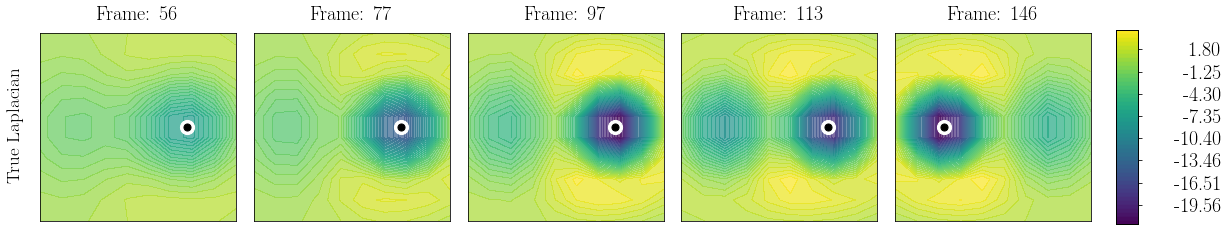

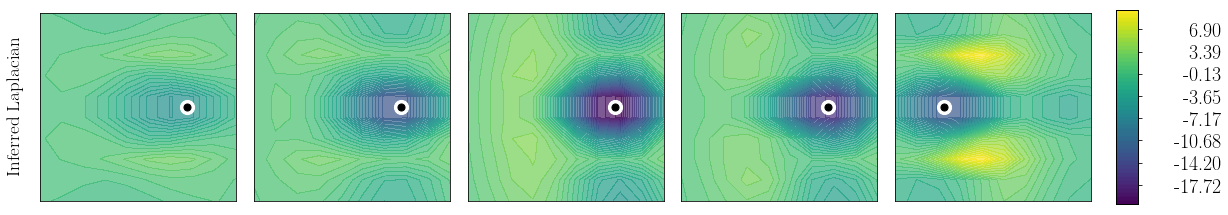

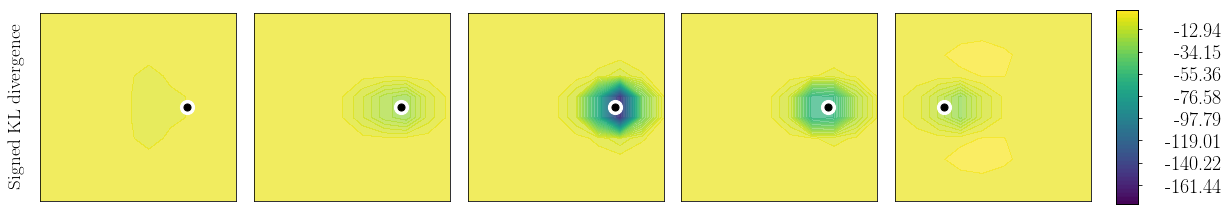

In [8]:
plot_laplacian(dic['X_true'], dic['Y_true'], 
               dic['lap_true'], dic['lap_inf'], 
               dic['xloc_syn'], dic['yloc_syn'], 
               dic['skl_div_syn'], T=[56,77,97,113,146], state = 'var')